In [1]:
import pandas as pd
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
import numpy as np
import os
os.getcwd()

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
raw_df = pd.read_json('/content/gdrive/My Drive/Colab Notebooks/News_Category_Dataset_v2.json', lines = True)
raw_df.tail()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


,authors,category,date,headline,link,short_description
200848,"Reuters, Reuters",TECH,2012-01-28,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...
200849,,SPORTS,2012-01-28,Maria Sharapova Stunned By Victoria Azarenka I...,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr..."
200850,,SPORTS,2012-01-28,"Giants Over Patriots, Jets Over Colts Among M...",https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked..."
200851,,SPORTS,2012-01-28,Aldon Smith Arrested: 49ers Linebacker Busted ...,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...
200852,,SPORTS,2012-01-28,Dwight Howard Rips Teammates After Magic Loss ...,https://www.huffingtonpost.com/entry/dwight-ho...,The five-time all-star center tore into his te...


In [3]:
print('Number of categories: ', len(raw_df.category.unique()))

Number of categories:  41


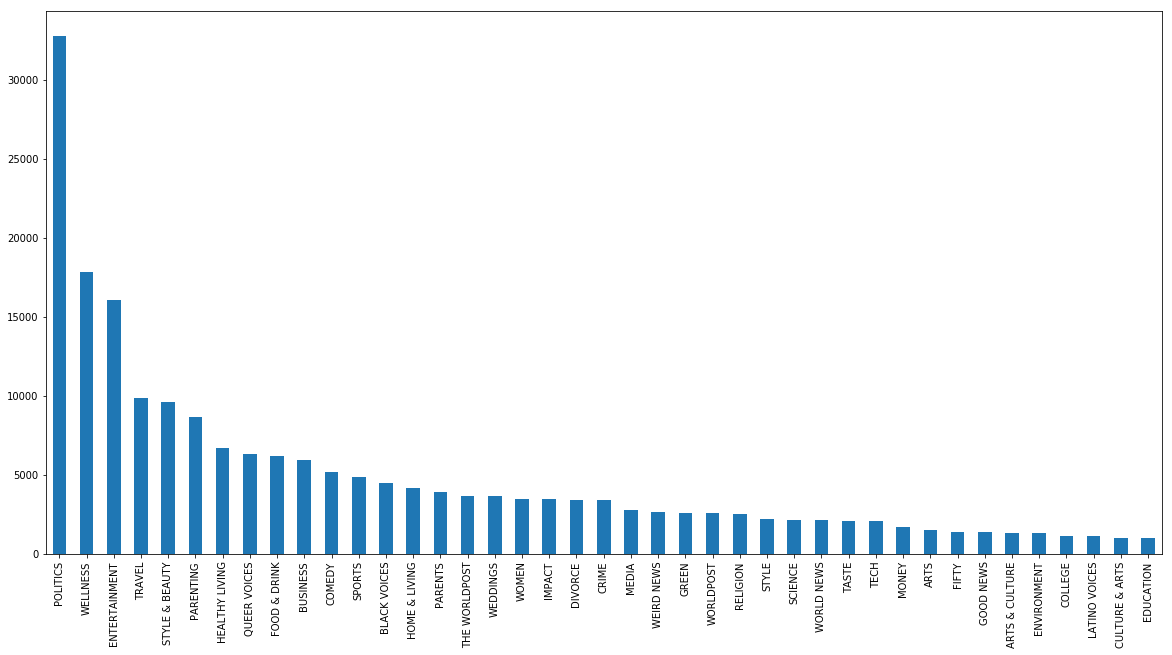

In [4]:
pd.value_counts(raw_df.category).plot(figsize=(20,10), kind='bar')

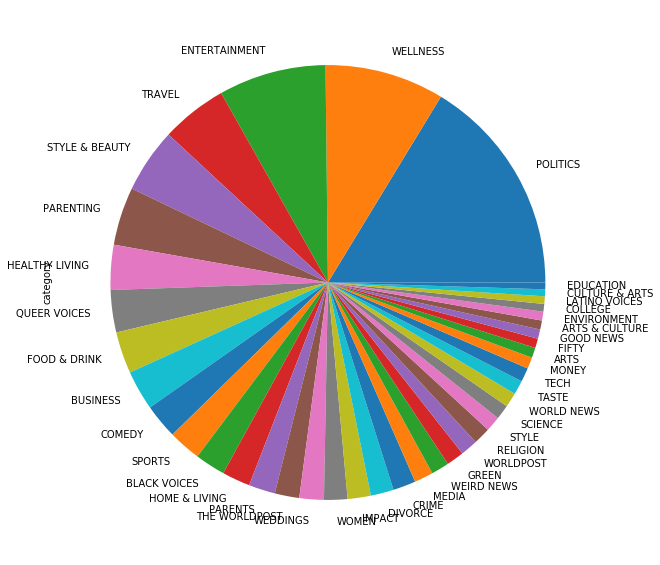

In [5]:
pd.value_counts(raw_df.category).plot(figsize=(10,10), kind='pie')

In [6]:
print('Number of rows without short description: ', sum(raw_df.short_description == ''))

Number of rows without short description:  19712


In [7]:
print('Number of rows without headline: ', sum(raw_df.headline == ''))

Number of rows without headline:  6


In [8]:
#Only use data contain headline or short description
df = raw_df[(raw_df.headline != '') | (raw_df.short_description != '')][['category', 'headline', 'short_description']]
#Combine headline and short description
df['text'] = df.headline + ' \n ' + df.short_description
df = df[['text', 'category']]
print('Size of dataset: ', df.shape)

Size of dataset:  (200848, 2)


In [9]:
letters_only = lambda x: re.sub('[^a-zA-Z]', ' ', x)
df.text = df.text.apply(letters_only)
df.head()

,text,category
0,There Were Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The ...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age ...,ENTERTAINMENT
3,Jim Carrey Blasts Castrato Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.text)
df['word_index'] = tokenizer.texts_to_sequences(df.text)

In [11]:
df.head()

,text,category,word_index
0,There Were Mass Shootings In Texas Last Week...,CRIME,"[60, 106, 1271, 2909, 7, 646, 136, 92, 29, 121..."
1,Will Smith Joins Diplo And Nicky Jam For The ...,ENTERTAINMENT,"[45, 1392, 2910, 22678, 5, 23907, 4951, 9, 1, ..."
2,Hugh Grant Marries For The First Time At Age ...,ENTERTAINMENT,"[5777, 4982, 7722, 9, 1, 81, 56, 23, 401, 1, 8..."
3,Jim Carrey Blasts Castrato Adam Schiff And D...,ENTERTAINMENT,"[2595, 10635, 3514, 52932, 2230, 12303, 5, 521..."
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT,"[36118, 29453, 1484, 101, 35, 7339, 3073, 2, 9..."


In [0]:
# from tf.keras.preprocessing.sequence import pad_sequences
MAXLEN = 100
catg_index = dict(enumerate([i for i in pd.value_counts(df.category).index]))
catg_index = {v: k for k,v in catg_index.items()}
df['category_index'] = df.category.apply(lambda x: catg_index.get(x))

In [13]:
df.head()

,text,category,word_index,category_index
0,There Were Mass Shootings In Texas Last Week...,CRIME,"[60, 106, 1271, 2909, 7, 646, 136, 92, 29, 121...",20
1,Will Smith Joins Diplo And Nicky Jam For The ...,ENTERTAINMENT,"[45, 1392, 2910, 22678, 5, 23907, 4951, 9, 1, ...",2
2,Hugh Grant Marries For The First Time At Age ...,ENTERTAINMENT,"[5777, 4982, 7722, 9, 1, 81, 56, 23, 401, 1, 8...",2
3,Jim Carrey Blasts Castrato Adam Schiff And D...,ENTERTAINMENT,"[2595, 10635, 3514, 52932, 2230, 12303, 5, 521...",2
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT,"[36118, 29453, 1484, 101, 35, 7339, 3073, 2, 9...",2


In [0]:
df_subset = df[df.category_index < 10]

In [0]:
PADDING = 'pre'
TRUNCATING = 'post'
def get_sequence(DF, padding, truncating):
    X = DF.word_index
    y = DF.category_index
    X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAXLEN, padding=padding, truncating=truncating)
    return X, y
X, y = get_sequence(df_subset, PADDING, TRUNCATING)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.33)


In [0]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [0]:
word2index = tokenizer.word_index

In [19]:
embeddings_index = {}
glove_dir = '/content/gdrive/My Drive/Colab Notebooks/glove.6B'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word2index) + 1, EMBEDDING_DIM))
unknown = []
known = []
for word, i in word2index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        known.append(word)
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        unknown.append(word)

In [21]:
print(len(unknown))
print(len(known))
len(word2index)

14098
70367


84465

In [22]:
embedding_matrix.shape

(84466, 100)

In [0]:
MAX_SEQUENCE_LENGTH = MAXLEN #max(df.words.apply(len))
EMBED_DROPOUT = 0
BIDIRECIONAL = True
EMBED_DIM = 100
EMBED_DROPOUT = 0
DROPOUT = 0.2
RECURRENT_DROPOUT = 0.2
LSTM_OUT_DIM = 50
BATCH_SIZE = 64
NUM_EPOCH = 20
SEQ_OUT = False
NUM_CATG = 10
REG_COEF = 0.01


In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word2index) + 1,
                              EMBEDDING_DIM,
                              weights=[embedding_matrix],
                              input_length = MAX_SEQUENCE_LENGTH, 
                              trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_OUT_DIM, 
                                                       dropout=DROPOUT, 
                                                       recurrent_dropout=RECURRENT_DROPOUT,
                                                       kernel_regularizer=tf.keras.regularizers.l2(REG_COEF),
                                                       bias_regularizer=tf.keras.regularizers.l2(REG_COEF),
                                                       return_sequences=SEQ_OUT)),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(NUM_CATG)),
    tf.keras.layers.Dense(NUM_CATG),
    tf.keras.layers.Activation('softmax'),

    ]
)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          8446600   
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 8,508,010
Trainable params: 8,508,010
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
filepath="/content/gdrive/My Drive/Colab Notebooks/weights_news_best.hdf5"

mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath, 
                           monitor='val_categorical_accuracy', 
                           verbose=1, 
                           save_best_only=True, 
                           save_weights_only=True, 
                           mode='max', 
                           period=1)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                              min_delta=0, 
                              patience=4, 
                              verbose=1, 
                              mode='auto', 
                              baseline=None, 
                              restore_best_weights=False)

reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.1, 
                                   patience=2, 
                                   verbose=1, 
                                   mode='min', 
                                   min_delta=0.0001, 
                                   cooldown=0, 
                                   min_lr=0)

history = model.fit(X_train,  y_train , 
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCH, verbose=1,
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
#                     validation_split=0.2,
                    validation_data=(X_val, y_val)
                   )

Train on 84003 samples, validate on 24121 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
83968/84003 [============================>.] - ETA: 0s - loss: 1.6669 - categorical_accuracy: 0.6416
Epoch 00001: val_categorical_accuracy improved from -inf to 0.78670, saving model to weights_news_best.hdf5
84003/84003 [==============================] - 672s 8ms/sample - loss: 1.6666 - categorical_accuracy: 0.6416 - val_loss: 0.8418 - val_categorical_accuracy: 0.7867
Epoch 2/20
83968/84003 [============================>.] - ETA: 0s - loss: 0.7691 - categorical_accuracy: 0.7963
Epoch 00002: val_categorical_accuracy improved from 0.78670 to 0.80971, saving model to weights_news_best.hdf5
84003/84003 [==============================] - 671s 8ms/sample - loss: 0.7691 - categorical_accuracy: 0.7962 - val_loss: 0.6920 - val_categorical_accuracy: 0.8097
Epoch 3/20
83968/84003 [============================>.] - ETA: 0s - loss: 0.6208 - categorical_accuracy: 0.8316
Epoch 00003: val_cate